# Reinforcement learning

In [ ]:
%pip install numpy gym

## RL QLearning

In [63]:
import matplotlib.pyplot as plt
import numpy as np

def plot_trajectory(trajectory, predictions):
    # Tworzenie figury z większym rozmiarem (np. 12x8 cali)
    plt.figure(figsize=(14, 10))

    # Separacja danych na normalne i anomalie
    normal = trajectory[trajectory[:, -1] == 0]
    anomalies = trajectory[trajectory[:, -1] == 1]
    predicted_anomalies = trajectory[np.array(predictions) == 1]

    # Rysowanie punktów
    plt.scatter(normal[:, 1], normal[:, 0], c='blue', label='Normal', alpha=0.5, s=50)
    plt.scatter(anomalies[:, 1], anomalies[:, 0], c='red', label='True Anomalies', marker='x', s=100)
    plt.scatter(predicted_anomalies[:, 1], predicted_anomalies[:, 0], c='green', 
                label='Predicted Anomalies', marker='o', s=150, alpha=0.3)

    # Dodanie etykiet i tytułu
    plt.xlabel('Longitude', fontsize=14)
    plt.ylabel('Latitude', fontsize=14)
    plt.title('AIS Trajectory with Anomalies', fontsize=16)

    # Dodanie siatki dla lepszej czytelności
    plt.grid(True, linestyle='--', alpha=0.7)

    # Dodanie legendy
    plt.legend(fontsize=12)

    # Wyświetlenie wykresu
    plt.show()



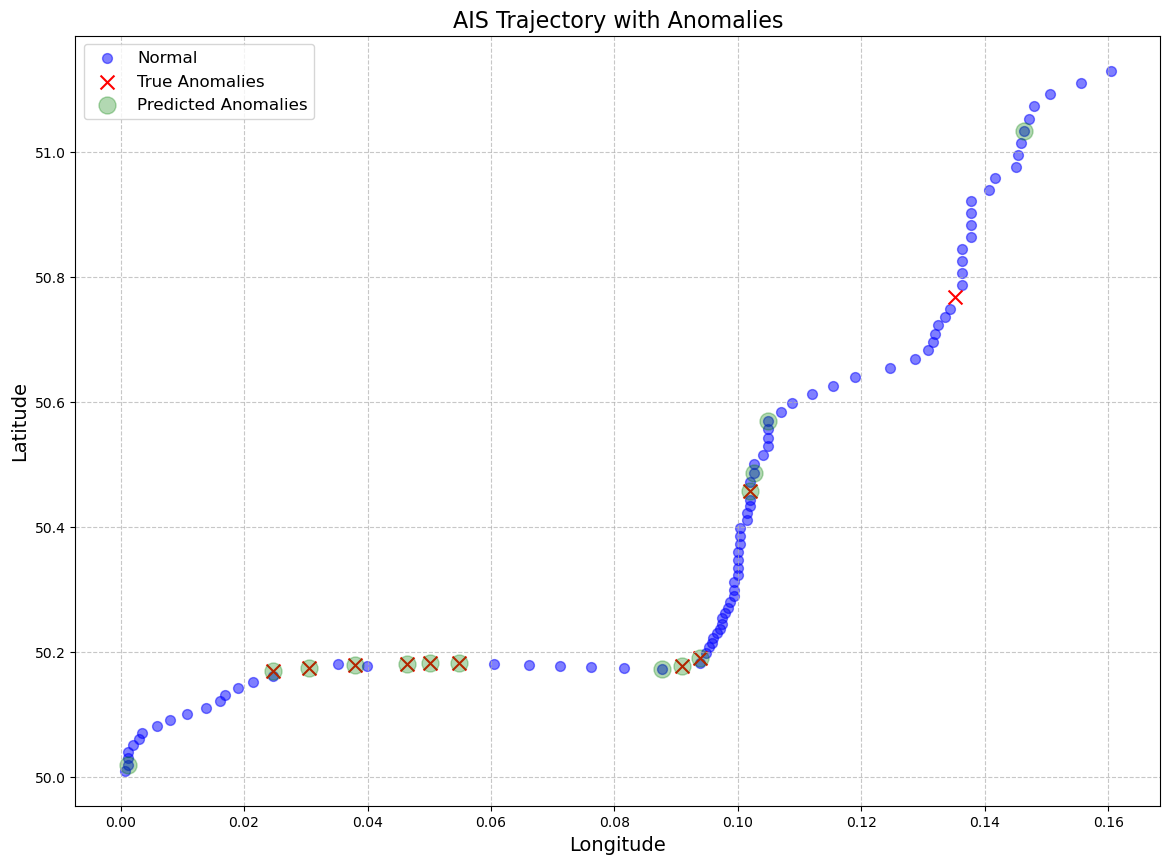

Accuracy: 0.94
Trajectory saved to ais_trajectory.csv


In [89]:
import numpy as np
import random
import gym
from gym import spaces
import pandas as pd

# 1. Generator sygnału AIS
class AISGenerator:
    def __init__(self):
        self.lat = 50.0  # Początkowa szerokość geograficzna
        self.lon = 0.0   # Początkowa długość geograficzna
        self.speed = 10.0  # Prędkość w węzłach
        self.course = 0.0  # Kurs w stopniach
        self.time = 0.0   # Czas w sekundach
        self.max_steps = 100  # Maksymalna liczba kroków w symulacji

    def generate_normal_step(self):
        """Generuje normalny krok ruchu statku"""
        # Normalny ruch: małe zmiany w prędkości i kursie
        self.speed += np.random.normal(0, 0.5)  # Losowa zmiana prędkości
        self.course += np.random.normal(0, 5.0)  # Losowa zmiana kursu
        self.speed = np.clip(self.speed, 0, 20)  # Ograniczenie prędkości
        self.course = np.clip(self.course, 0, 360)  # Ograniczenie kursu
        # Aktualizacja pozycji (uproszczona, bez projekcji geograficznej)
        self.lat += self.speed * np.cos(np.radians(self.course)) * 0.001
        self.lon += self.speed * np.sin(np.radians(self.course)) * 0.001
        self.time += 60  # Krok czasowy: 60 sekund
        return [self.lat, self.lon, self.speed, self.course, self.time]

    def generate_anomaly_step(self):
        """Generuje anomalię, np. nagłą zmianę kursu lub prędkości"""
        self.speed += np.random.uniform(-5, 5)  # Duża zmiana prędkości
        self.course += np.random.uniform(-90, 90)  # Duża zmiana kursu
        self.speed = np.clip(self.speed, 0, 20)
        self.course = np.clip(self.course, 0, 360)
        self.lat += self.speed * np.cos(np.radians(self.course)) * 0.001
        self.lon += self.speed * np.sin(np.radians(self.course)) * 0.001
        self.time += 60
        return [self.lat, self.lon, self.speed, self.course, self.time]

    def generate_trajectory(self, anomaly_prob=0.1):
        """Generuje trajektorię z szansą na anomalię"""
        trajectory = []
        for _ in range(self.max_steps):
            if random.random() < anomaly_prob:
                trajectory.append(self.generate_anomaly_step() + [1])  # 1 = anomalia
            else:
                trajectory.append(self.generate_normal_step() + [0])  # 0 = normalny
        return np.array(trajectory)

# 2. Środowisko RL dla wykrywania anomalii
class AISEnvironment(gym.Env):
    def __init__(self, trajectory):
        super(AISEnvironment, self).__init__()
        self.trajectory = trajectory  # Dane AIS
        self.current_step = 0
        self.action_space = spaces.Discrete(2)  # 0: normalny, 1: anomalia
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(5,), dtype=np.float32)
        self.max_steps = len(trajectory)

    def reset(self):
        self.current_step = 0
        return self.trajectory[self.current_step, :-1]  # Stan: [lat, lon, speed, course, time]

    def step(self, action):
        true_label = self.trajectory[self.current_step, -1]  # Czy to anomalia (0 lub 1)
        reward = 1 if action == true_label else -1  # Nagroda: +1 za poprawną klasyfikację, -1 za błąd
        self.current_step += 1
        done = self.current_step >= self.max_steps
        next_state = self.trajectory[self.current_step, :-1] if not done else np.zeros(5)
        return next_state, reward, done, {}

    def render(self):
        pass  # Opcjonalnie: wizualizacja trajektorii

# 3. Prosty algorytm Q-learning
class QLearningAgent:
    def __init__(self, state_size, action_size, learning_rate=0.1, discount_factor=0.95, epsilon=0.1):
        self.q_table = {}  # Słownik zamiast tablicy dla ciągłych stanów
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.action_size = action_size

    def discretize_state(self, state):
        """Upraszcza stan do klucza w Q-table (dyskretyzacja)"""
        return tuple(np.round(state, 2))  # Zaokrąglenie dla uproszczenia

    def get_action(self, state):
        state_key = self.discretize_state(state)
        if random.random() < self.epsilon:  # Eksploracja
            return random.randint(0, self.action_size - 1)
        if state_key not in self.q_table:
            self.q_table[state_key] = np.zeros(self.action_size)
        return np.argmax(self.q_table[state_key])  # Eksploatacja

    def update(self, state, action, reward, next_state):
        state_key = self.discretize_state(state)
        next_state_key = self.discretize_state(next_state)
        if state_key not in self.q_table:
            self.q_table[state_key] = np.zeros(self.action_size)
        if next_state_key not in self.q_table:
            self.q_table[next_state_key] = np.zeros(self.action_size)
        q_value = self.q_table[state_key][action]
        next_max = np.max(self.q_table[next_state_key])
        self.q_table[state_key][action] += self.lr * (reward + self.gamma * next_max - q_value)

# 4. Symulacja
def main():
    # Generowanie danych AIS
    ais = AISGenerator()
    trajectory = ais.generate_trajectory(anomaly_prob=0.1)
    env = AISEnvironment(trajectory)
    agent = QLearningAgent(state_size=5, action_size=2)

    # Trening agenta
    episodes = 100
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False
        while not done:
            action = agent.get_action(state)
            next_state, reward, done, _ = env.step(action)
            agent.update(state, action, reward, next_state)
            state = next_state
            total_reward += reward
        #print(f"Episode {episode + 1}, Total Reward: {total_reward}")

    # Testowanie agenta
    state = env.reset()
    done = False
    predictions = []
    while not done:
        action = agent.get_action(state)
        predictions.append(action)
        state, _, done, _ = env.step(action)

    plot_trajectory(trajectory, predictions)

    # Wyniki
    true_labels = trajectory[:, -1]
    accuracy = np.mean(predictions == true_labels)
    print(f"Accuracy: {accuracy:.2f}")

    # Zapisanie trajektorii do pliku CSV
    df = pd.DataFrame(trajectory, columns=['lat', 'lon', 'speed', 'course', 'time', 'is_anomaly'])
    df['predicted_anomaly'] = predictions + [0] * (len(trajectory) - len(predictions))  # Wyrównanie długości
    df.to_csv('ais_trajectory.csv', index=False)
    print("Trajectory saved to ais_trajectory.csv")


if __name__ == "__main__":
    main()